# Laboratorio 5. Redes Neuronales Recurrentes (RNN) para Series de Tiempo

- Diego Duarte 
- Paula Barillas

## Aplicación de Redes Neuronales Recurrentes (RNN, específicamente LSTM) para la predicción de series temporales reales

**Datos:** Producción industrial de helados y postres congelados en EE.UU. (FRED, Reserva Federal de St. Louis)

### Objetivos de aprendizaje
1. Comprender y aplicar los conceptos básicos del preprocesamiento de series de tiempo para modelado predictivo.
2. Implementar un generador de secuencias temporales para entrenamiento de redes.
3. Diseñar, entrenar y evaluar un modelo de tipo LSTM para predicción de series temporales.
4. Analizar y comparar el desempeño del modelo mediante métricas y visualizaciones.
5. Documentar adecuadamente el proceso seguido, justificando decisiones de diseño y parámetros.

---

## 1. Carga y exploración de datos
En esta sección se importan las librerías necesarias y se descarga la serie temporal de producción industrial de helados y postres congelados en EE.UU. desde FRED.

,IPN31152N
DATE,
2000-01-01,93.6497
2000-02-01,111.6591
2000-03-01,125.4885
2000-04-01,136.9998
2000-05-01,136.0725


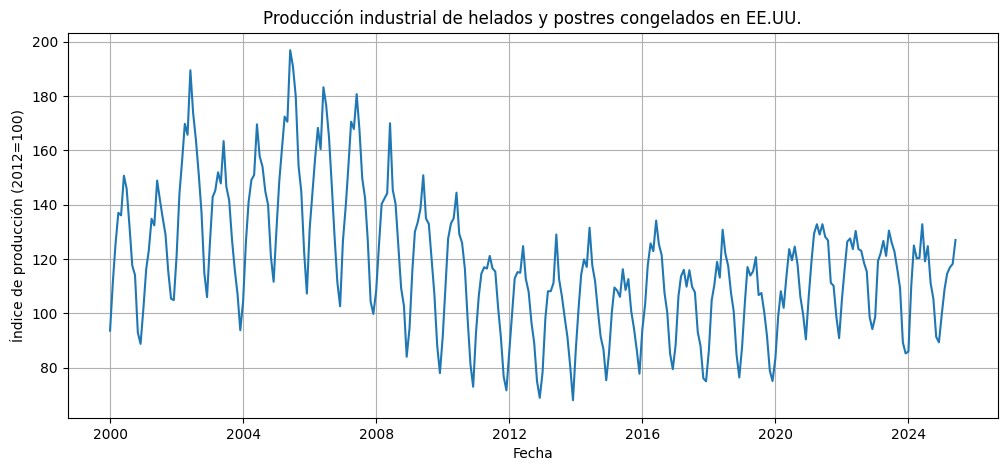

In [11]:
# !pip install pandas_datareader matplotlib --quiet
import pandas as pd
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
import datetime


start = datetime.datetime(2000, 1, 1)
end = datetime.datetime.today()

# datos de FRED
serie = pdr.DataReader('IPN31152N', 'fred', start, end)
serie = serie.dropna()  # Eliminar valores nulos si existen

# Visualizar las primeras filas
display(serie.head())

# Graficar la serie temporal
plt.figure(figsize=(12,5))
plt.plot(serie.index, serie['IPN31152N'])
plt.title('Producción industrial de helados y postres congelados en EE.UU.')
plt.xlabel('Fecha')
plt.ylabel('Índice de producción (2012=100)')
plt.grid(True)
plt.show()

## 2. División de conjuntos de entrenamiento y prueba
Se dividió la serie temporal en dos conjuntos:
- **Entrenamiento:** Todos los datos excepto los últimos 24 meses.
- **Prueba:** Los últimos 24 meses para evaluar la capacidad predictiva del modelo.

In [12]:
# División de los datos
n_test = 24  # Últimos 24 meses para prueba
train = serie.iloc[:-n_test]
test = serie.iloc[-n_test:]

print(f'Tamaño entrenamiento: {len(train)}')
print(f'Tamaño prueba: {len(test)}')
print('Rango entrenamiento:', train.index.min().date(), 'a', train.index.max().date())
print('Rango prueba:', test.index.min().date(), 'a', test.index.max().date())

Tamaño entrenamiento: 282
Tamaño prueba: 24
Rango entrenamiento: 2000-01-01 a 2023-06-01
Rango prueba: 2023-07-01 a 2025-06-01


## 3. Normalización y preparación de datos
Para mejorar el desempeño del modelo LSTM, se normalizaron los datos usando MinMaxScaler y se preparo las secuencias con TimeSeriesGenerator de Keras.

In [13]:
# !pip install scikit-learn tensorflow --quiet
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# normalización de los datos
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

# pparámetros para el generador
n_input = 12  # meses de entrada para predecir el siguiente
batch_size = 1

# secuencias para entrenamiento
generator = TimeseriesGenerator(train_scaled, train_scaled, length=n_input, batch_size=batch_size)

print(f'Número de secuencias de entrenamiento: {len(generator)}')

Número de secuencias de entrenamiento: 270


## 4. Construcción del modelo: 
Definan una red LSTM secuencial con técnicas de regularización. Queda a discreción de ustedes el número de capas LSTM y el número de perceptrones (neuronas)

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Crear el modelo secuencial
model = Sequential()

# Primera capa LSTM con regularización (Dropout)
model.add(LSTM(50, activation='tanh', input_shape=(n_input, 1), return_sequences=True))
model.add(Dropout(0.2))  # Dropout del 20%

# Segunda capa LSTM
model.add(LSTM(30, activation='tanh'))
model.add(Dropout(0.2))

# Capa de salida
model.add(Dense(1))  # Predecimos un valor continuo

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Resumen del modelo
model.summary()


c:\Users\diego\OneDrive\Escritorio\2025\Semestre VIII\DataScience\tf2-env\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 12, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 30)             │         9,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,151 (78.71 KB)

 Trainable params: 20,151 (78.71 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
epochs = 100
history = model.fit(generator, epochs=epochs, verbose=1)

Epoch 1/100


c:\Users\diego\OneDrive\Escritorio\2025\Semestre VIII\DataScience\tf2-env\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


270/270 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0536
Epoch 2/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0355
Epoch 3/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0244
Epoch 4/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0140
Epoch 5/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0111
Epoch 6/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0112
Epoch 7/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0093
Epoch 8/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0094
Epoch 9/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0106
Epoch 10/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0090
Epoch 11/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0083
Epoch 12/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0074
Epoch 13/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0075
Epoch 14/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0085
Epoch 15/100
270/270 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step -

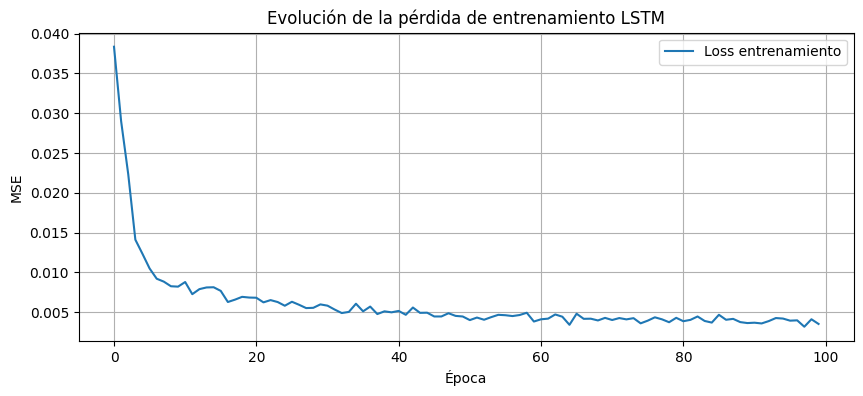

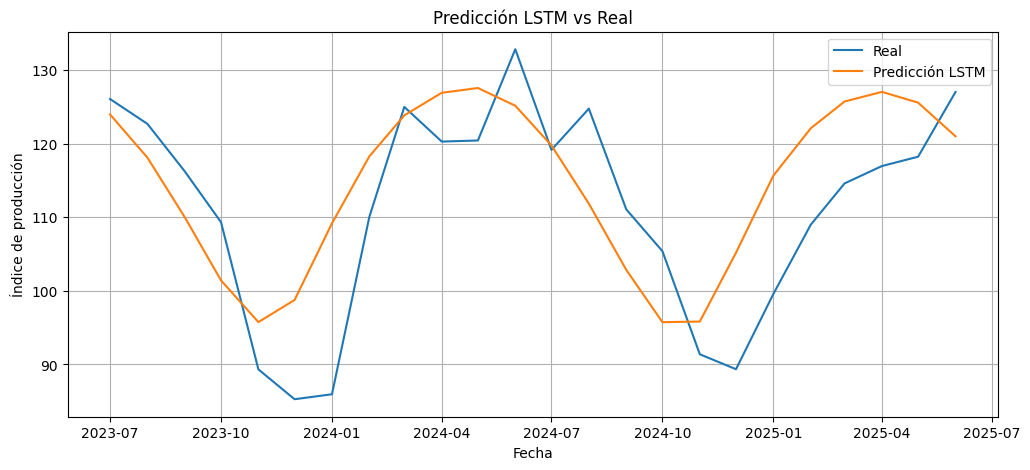

In [16]:
import numpy as np

# Graficar la pérdida durante el entrenamiento
plt.figure(figsize=(10,4))
plt.plot(history.history['loss'], label='Loss entrenamiento')
plt.title('Evolución de la pérdida de entrenamiento LSTM')
plt.xlabel('Época')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.show()

# Predicción en datos de prueba
test_inputs = train_scaled[-n_input:].tolist()  # Últimos n_input del train
predictions = []

for i in range(len(test)):
    x_input = np.array(test_inputs[-n_input:]).reshape((1, n_input, 1))
    yhat = model.predict(x_input, verbose=0)
    predictions.append(yhat[0][0])
    test_inputs.append([yhat[0][0]])

# Desescalar predicciones
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1,1))

# Graficar resultados
plt.figure(figsize=(12,5))
plt.plot(serie.index[-n_test:], test, label='Real')
plt.plot(serie.index[-n_test:], predictions, label='Predicción LSTM')
plt.title('Predicción LSTM vs Real')
plt.xlabel('Fecha')
plt.ylabel('Índice de producción')
plt.legend()
plt.grid(True)
plt.show()
